# Связанные тетрадки
- [EDA](https://www.kaggle.com/maximmezhov/cardiospike-eda)  
- [Подготовка датасета](https://www.kaggle.com/maximmezhov/cardiospike-feature-development)  
- [baseline](https://www.kaggle.com/maximmezhov/cardiospike-baseline)

In [1]:
import pandas as pd
import lightgbm
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score

In [2]:
# Const
RANDOM_STATE = 0

In [3]:
def make_XY(df):
    """
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler.pkl was saved in output directory')

    return X, y


def make_XY_v2(df):
    """
    Feature 'x-(x-1)' excluded.
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time', 'x-(x-1)'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler_v2.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler_v2.pkl was saved in output directory')

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()

# Pipeline

In [4]:
# load data
with open('../input/cardiospike-feature-development/dataset_v1.pkl', 'rb') as f:
    df = pickle.load(f)
    
# make X and y
X, y = make_XY(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler.pkl was saved in output directory
train (47290, 15) (47290,)
test (11823, 15) (11823,)


In [5]:
model = lightgbm.LGBMClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)

# first params search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1]
}
gscv = GridSearchCV(model, param_grid, scoring='f1_micro', cv=StratifiedKFold(), verbose=False)
gscv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(n_estimators=400, random_state=0),
             param_grid={'learning_rate': [0.001, 0.01, 0.1]},
             scoring='f1_micro', verbose=False)

In [6]:
# estimate result
print(gscv.best_params_)
print(gscv.best_score_)

{'learning_rate': 0.01}
0.8968084210239532


In [7]:
gscv.best_estimator_

LGBMClassifier(learning_rate=0.01, n_estimators=400, random_state=0)

In [8]:
gscv.cv_results_

{'mean_fit_time': array([1.70466771, 1.81367054, 1.43129458]),
 'std_fit_time': array([0.02804763, 0.23246451, 0.04296861]),
 'mean_score_time': array([0.09054651, 0.16926827, 0.10398812]),
 'std_score_time': array([0.00987924, 0.02406173, 0.00221005]),
 'param_learning_rate': masked_array(data=[0.001, 0.01, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.001},
  {'learning_rate': 0.01},
  {'learning_rate': 0.1}],
 'split0_test_score': array([0.84868477, 0.92819081, 0.93022076]),
 'split1_test_score': array([0.84868477, 0.89199019, 0.87659646]),
 'split2_test_score': array([0.84860019, 0.83405227, 0.83286814]),
 'split3_test_score': array([0.84867197, 0.91245136, 0.91363559]),
 'split4_test_score': array([0.84867197, 0.91735747, 0.91981052]),
 'mean_test_score': array([0.84866273, 0.89680842, 0.8946263 ]),
 'std_test_score': array([3.17920198e-05, 3.35063258e-02, 3.57818646e-02]),
 'rank_test_score': ar

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.21137944013417437)])})


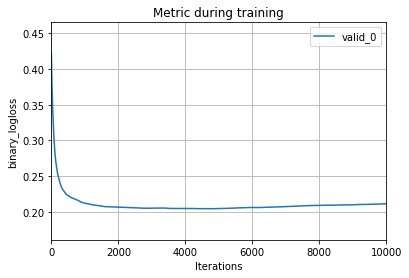

In [9]:
model = lightgbm.LGBMClassifier(n_estimators=10000, random_state=RANDOM_STATE, n_jobs=-1, learning_rate=0.01)
model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='f1_micro', verbose=False)
lightgbm.plot_metric(model);
print(model.best_score_)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.2046890843231054)])})


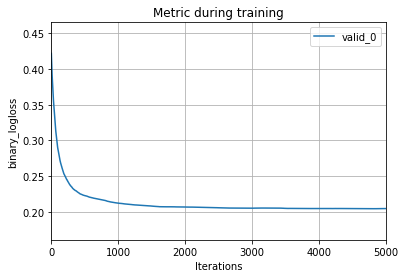

In [10]:
model = lightgbm.LGBMClassifier(n_estimators=5000, random_state=RANDOM_STATE, n_jobs=-1, learning_rate=0.01)
model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='f1_micro', verbose=False)
lightgbm.plot_metric(model);
print(model.best_score_)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.2051069153295308)])})
2937


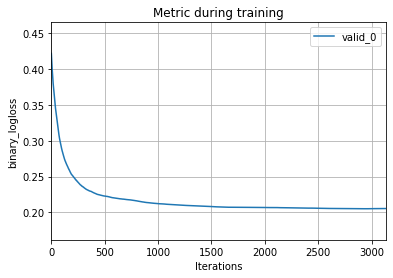

In [11]:
model = lightgbm.LGBMClassifier(n_estimators=6000, 
                                random_state=RANDOM_STATE, n_jobs=-1, 
                                learning_rate=0.01)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test), eval_metric='f1_micro', 
          verbose=False, early_stopping_rounds=200)
lightgbm.plot_metric(model);
print(model.best_score_)
print(model.best_iteration_)

In [12]:
y_pred = model.predict(X_test)
print('baseline score =', 0.9299670134483634)
print('current score =', f1_score(y_test, y_pred, average='micro'))

baseline score = 0.9299670134483634
current score = 0.9314894696777468


In [13]:
model.get_params

<bound method LGBMModel.get_params of LGBMClassifier(learning_rate=0.01, n_estimators=6000, random_state=0)>

In [14]:
print(model.best_iteration_)

2937


In [15]:
# save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [16]:
model_v2 = lightgbm.LGBMClassifier(n_estimators=2937, 
                                random_state=RANDOM_STATE, n_jobs=-1, 
                                learning_rate=0.01)
model_v2.fit(X_train, y_train, verbose=False)

y_pred = model_v2.predict(X_test)
print('model score =', 0.9314894696777468)
print('model with n_estimators=2937 score =', f1_score(y_test, y_pred, average='micro'))

model score = 0.9314894696777468
model with n_estimators=2937 score = 0.9314894696777468


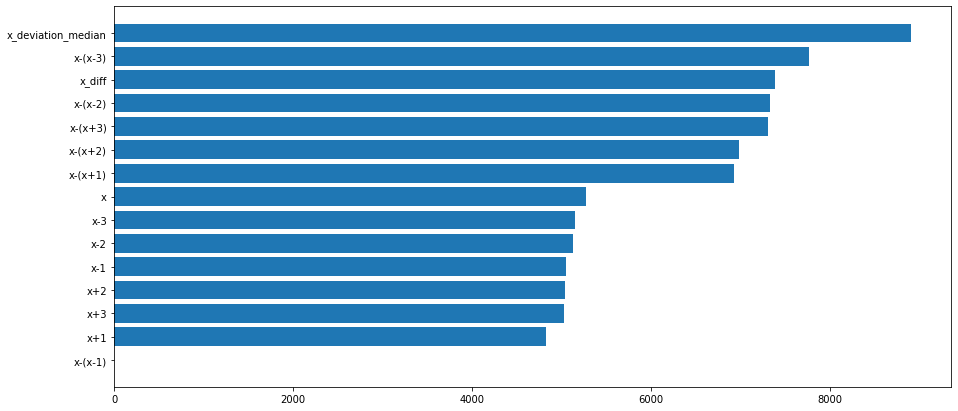

In [17]:
importance = model.feature_importances_
features = df.drop(['y','id','time'],axis=1).columns

sorted_indexes = np.argsort(importance)
fig = plt.figure(figsize=(15,7))
plt.barh(y=features[sorted_indexes], width=importance[sorted_indexes]);

# model v2
'x-(x-1)' excluded from fearutes

In [18]:
# load data
with open('../input/cardiospike-feature-development/dataset_v1.pkl', 'rb') as f:
    df = pickle.load(f)
    
# make X and y
X,y = make_XY_v2(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler_v2.pkl was saved in output directory
train (47290, 14) (47290,)
test (11823, 14) (11823,)


In [19]:
model_v2 = lightgbm.LGBMClassifier(n_estimators=2937,
                                   random_state=RANDOM_STATE, n_jobs=-1,
                                   learning_rate=0.01)
model_v2.fit(X_train, y_train, verbose=False)

y_pred = model_v2.predict(X_test)
print('model score =', 0.9314894696777468)
print('model_v2 without x-(x-1) score =', f1_score(y_test, y_pred, average='micro'))

model score = 0.9314894696777468
model_v2 without x-(x-1) score = 0.9314894696777468


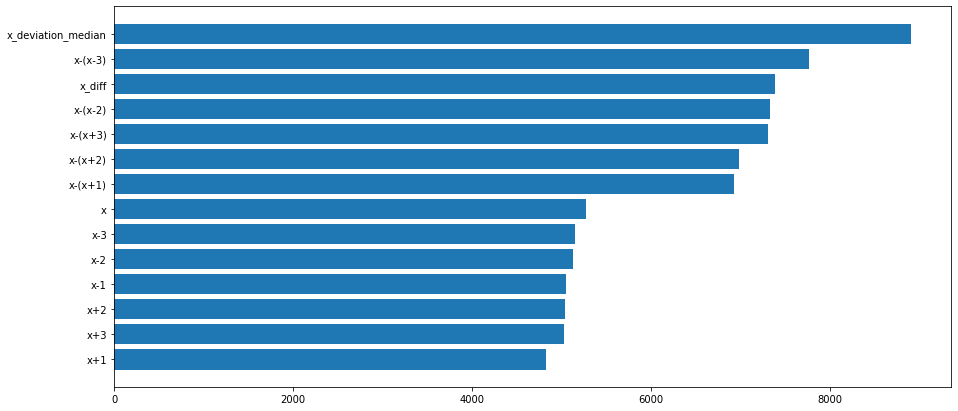

In [20]:
importance = model_v2.feature_importances_
features = df.drop(['y','id','time', 'x-(x-1)'],axis=1).columns

sorted_indexes = np.argsort(importance)
fig = plt.figure(figsize=(15,7))
plt.barh(y=features[sorted_indexes], width=importance[sorted_indexes]);

# model v3 - best

In [21]:
# load data
with open('../input/cardiospike-feature-development/dataset_v1.pkl', 'rb') as f:
    df = pickle.load(f)
    
# make X and y
X,y = make_XY_v2(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler_v2.pkl was saved in output directory
train (47290, 14) (47290,)
test (11823, 14) (11823,)


In [22]:
param_grid = {
    'num_leaves': [10, 50, 80],  # 31 is default
    'max_depth': [-1, 7, 14]  # -1 is default
}
model_v3 = lightgbm.LGBMClassifier(n_estimators=2937,
                                   random_state=RANDOM_STATE, n_jobs=-1,
                                   learning_rate=0.01)
gscv = GridSearchCV(model_v3, param_grid, scoring='f1_micro', 
                    n_jobs=-1, cv=StratifiedKFold(), verbose=False)
gscv.fit(X,y)

# estimate result
print(gscv.best_params_)
print(gscv.best_score_)

{'max_depth': 14, 'num_leaves': 50}
0.8954214115715402


In [23]:
param_grid = {
    'num_leaves': [40, 50, 60],  # 31 is default
    'max_depth': [10, 14, 20]  # -1 is default
}
model_v3 = lightgbm.LGBMClassifier(n_estimators=2937,
                                   random_state=RANDOM_STATE, n_jobs=-1,
                                   learning_rate=0.01)
gscv = GridSearchCV(model_v3, param_grid, scoring='f1_micro', 
                    n_jobs=-1, cv=StratifiedKFold(), verbose=False)
gscv.fit(X,y)

# estimate result
print(gscv.best_params_)
print(gscv.best_score_)

{'max_depth': 14, 'num_leaves': 50}
0.8954214115715402


In [24]:
# замиксуем лучшие пары параметров
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 14]
}
model_v3 = lightgbm.LGBMClassifier(n_estimators=2937,
                                   random_state=RANDOM_STATE, n_jobs=-1,
                                   learning_rate=0.01)
gscv = GridSearchCV(model_v3, param_grid, scoring='f1_micro', 
                    n_jobs=-1, cv=StratifiedKFold(), verbose=False)
gscv.fit(X,y)

# estimate result
print(gscv.best_params_)
print(gscv.best_score_)

{'max_depth': 14, 'num_leaves': 50}
0.8954214115715402


> побеждают `{'max_depth': 14, 'num_leaves': 50}`

In [25]:
model_v3 = lightgbm.LGBMClassifier(n_estimators=2937,
                                   random_state=RANDOM_STATE, n_jobs=-1,
                                   learning_rate=0.01, max_depth=14, num_leaves=50)
model_v3.fit(X_train, y_train, verbose=False)

y_pred = model_v3.predict(X_test)
print('previous best score =', 0.9314894696777468)
print('model_v3 score =', f1_score(y_test, y_pred, average='micro'))

previous best score = 0.9314894696777468
model_v3 score = 0.9318277932842765


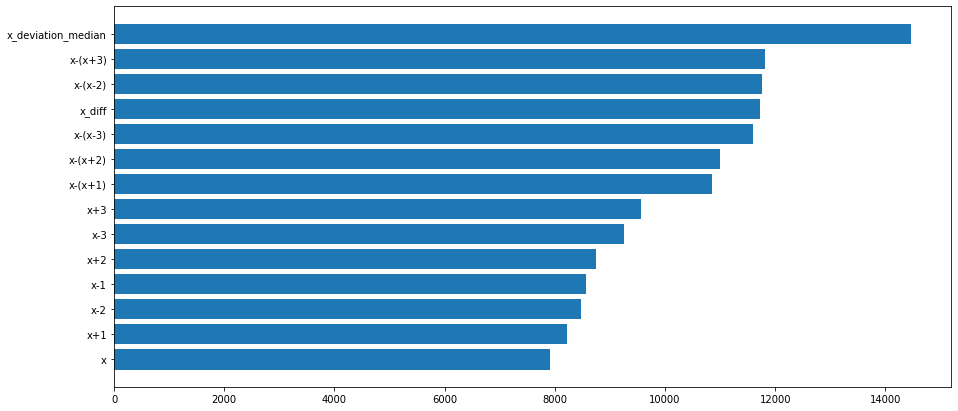

In [26]:
importance = model_v3.feature_importances_
features = df.drop(['y','id','time', 'x-(x-1)'],axis=1).columns

sorted_indexes = np.argsort(importance)
fig = plt.figure(figsize=(15,7))
plt.barh(y=features[sorted_indexes], width=importance[sorted_indexes]);

In [27]:
# save model
with open('model_v3.pkl', 'wb') as f:
    pickle.dump(model_v3, f)

# model v4

In [28]:
# load data
with open('../input/cardiospike-feature-development/dataset_v1.pkl', 'rb') as f:
    df = pickle.load(f)
    
# make X and y
X,y = make_XY(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler.pkl was saved in output directory
train (47290, 15) (47290,)
test (11823, 15) (11823,)


In [29]:
model_v4 = lightgbm.LGBMClassifier(n_estimators=2937,
                                   random_state=RANDOM_STATE, n_jobs=-1,
                                   learning_rate=0.01, max_depth=14, num_leaves=50)
model_v4.fit(X_train, y_train, verbose=False)

y_pred = model_v4.predict(X_test)
print('previous best score =', 0.9318277932842765)
print('model_v4 score =', f1_score(y_test, y_pred, average='micro'))

previous best score = 0.9318277932842765
model_v4 score = 0.9318277932842765


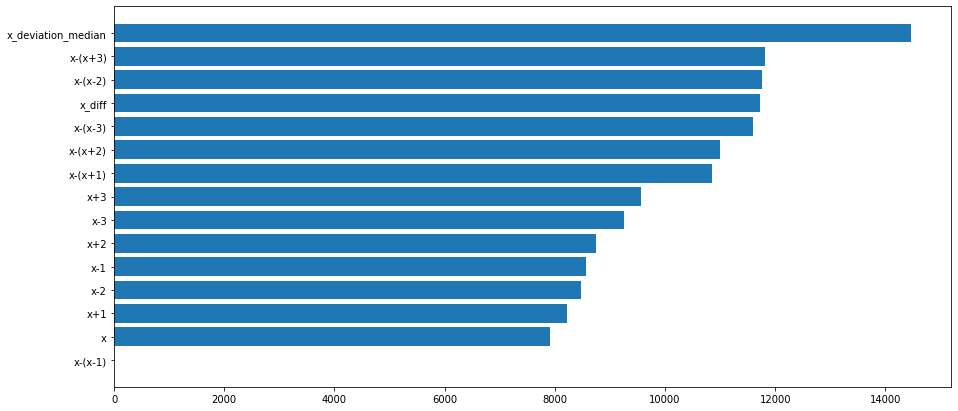

In [30]:
importance = model_v4.feature_importances_
features = df.drop(['y','id','time'],axis=1).columns

sorted_indexes = np.argsort(importance)
fig = plt.figure(figsize=(15,7))
plt.barh(y=features[sorted_indexes], width=importance[sorted_indexes]);